<a href="https://colab.research.google.com/github/tural199823/bert_fine_tuning/blob/main/Fine_tuned_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Sequence Classification

This project focuses on fine-tuning a BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification, leveraging LoRa (Low-Rank Adaptation) techniques. The dataset employed originates from the AG News dataset curated by fancyzhx (fancyzhx/ag_news).

For seamless execution in Colab, ensure you have the 🤗 Transformers, 🤗 Datasets, and 🤗 Accelerate libraries installed. These libraries are crucial for efficient experimentation and deployment of state-of-the-art natural language processing models.


In [1]:
!pip install transformers datasets torch
!pip install -q -U bitsandbytes
!pip install transformers[torch] accelerate -U
!pip install -q evaluate
!pip install peft
import re
import bitsandbytes
from datasets import load_dataset
import transformers
import accelerate
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, PeftModel
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoModelForSequenceClassification, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
import numpy as np
import evaluate
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(transformers.__version__)
print(accelerate.__version__)
print(bitsandbytes.__version__)

4.41.1
0.30.1
0.43.1


# Load the dataset

**Dataset Summary**

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004.

**Labels in the dataset are listed below:**
1. World
2. Sports
3. Business
4. Sci/Tech

In [4]:
dataset = load_dataset("ag_news")

**Tokenizing** your dataset before training is a crucial step because it converts the raw text into a format that can be understood and processed by the BERT model. BERT, like other transformer models, operates on tokenized inputs.

The "preprocess_function" below defines how the text data should be tokenized, padded to a maximum length, and truncated if necessary. The map function applies this preprocessing function to the entire dataset efficiently.

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

This code splits the encoded dataset into training and validation sets. It shuffles the data to ensure randomness and selects a specific number of samples for each set. You can increase the number of training samples.

In [6]:
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(8000))
val_dataset = encoded_dataset["test"].shuffle(seed=42).select(range(700))

Let's verify if our dataset has equal label representation in both the training and testing sets.

In [7]:
labels = [0,1,2,3]
labels_word = ['World', 'Sports', 'Business', 'Sci/Tech']
counts_train = []
for i in labels:
  counts_train.append(train_dataset['label'].count(i))

df_train = pd.DataFrame(counts_train, labels_word, columns = ['Number of Texts'])

counts_val = []
for i in labels:
  counts_val.append(val_dataset['label'].count(i))

df_test = pd.DataFrame(counts_val, labels_word, columns = ['Number of Texts'])

In [8]:
def plot_func(data_frame):
  data_frame.plot(kind='bar', legend=False)
  plt.title('Label Distribution in the Dataset')
  plt.xlabel('Labels')
  plt.ylabel('Number of Texts')
  plt.xticks(rotation=45)
  plt.show()

In [9]:
df_train['Number of Texts']

World       2020
Sports      2027
Business    1892
Sci/Tech    2061
Name: Number of Texts, dtype: int64

In [10]:
df_test['Number of Texts']

World       173
Sports      169
Business    179
Sci/Tech    179
Name: Number of Texts, dtype: int64

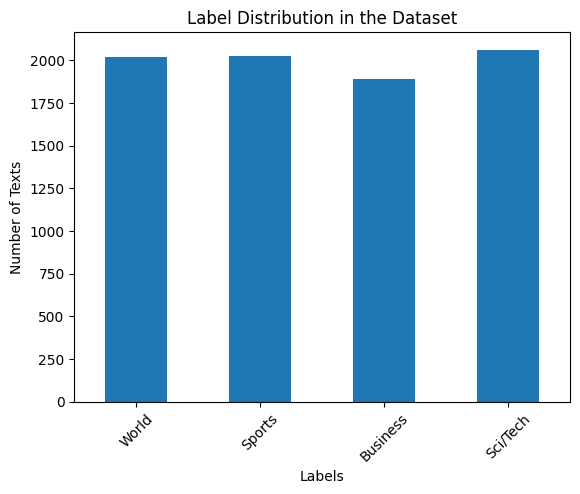

In [11]:
plot_func(df_train)

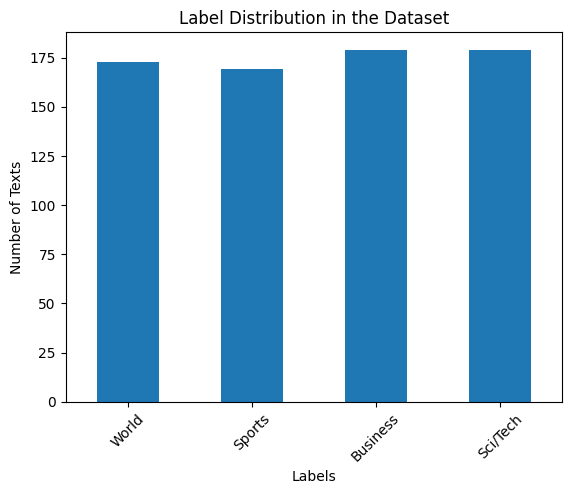

In [12]:
plot_func(df_test)

This dataset works well for our task. However, if your dataset is not equally represented, you can use techniques like stratified sampling. In this method, the population is divided into homogeneous subgroups called **strata**, and the appropriate number of instances is sampled from each stratum to ensure that the training and testing sets represent the overall population (*Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, page 56*).

# Training


**PEFT** (*Parameter-Efficient Fine-Tuning*) is a technique that fine-tunes models with fewer trainable parameters, improving efficiency while maintaining performance.

This code initializes a BERT model for sequence classification with 4 labels, configures **LoRA** (*Low-Rank Adaptation*) for efficient fine-tuning, and applies the LoRA configuration to the model.



**LoRa** (*Low-Rank Adaptation*) is a technique designed to optimize the fine-tuning process of large language models by significantly reducing the number of trainable parameters. How does it work?
It works by decomposing the parameter update matrix into the product of two smaller matrices. Instead of directly updating the large matrix of model weights, LoRa learns these two smaller matrices during fine-tuning. This results in a low-rank approximation that requires fewer parameters and computational resources.

In [13]:
model_base = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
)

lora_config = LoraConfig(
    r=2,
    lora_alpha=2,
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)
model = get_peft_model(model_base, lora_config)

model.config.use_cache = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.print_trainable_parameters()

trainable params: 227,332 || all params: 109,712,648 || trainable%: 0.2072


With LoRa and PEFT, we only need to train 227,332 parameters out of a total of 109,712,648.
This means only 0.2072% of the model's parameters are being fine-tuned, significantly reducing computational resources and time while still adapting the model effectively.


In [15]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.1",
  "type_vocab_size": 2,
  "use_cache": false,
  "vocab_size": 30522
}

This code loads the accuracy metric and defines a function to compute evaluation metrics by comparing model predictions to true labels.


In [16]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Code cells below sets up the training arguments, initializes a Trainer with the model and datasets, specifies evaluation and training configurations, and then starts the training process

In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=3,
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.480300,0.456457,0.838571
2,0.358300,0.420038,0.877143
3,0.377000,0.413532,0.880000


TrainOutput(global_step=3000, training_loss=0.5125916544596354, metrics={'train_runtime': 1965.9331, 'train_samples_per_second': 12.208, 'train_steps_per_second': 1.526, 'total_flos': 6331539456000000.0, 'train_loss': 0.5125916544596354, 'epoch': 3.0})

The model exhibits a consistent decrease in both training and validation loss over the epochs, indicating effective learning. Accuracy improves initially but then plateaus, suggesting the model is converging. To achieve better results, consider increasing the training set size and adjusting the Rank parameter of LoRa.

In [20]:
output_dir = './main_model'
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('./main_model/tokenizer_config.json',
 './main_model/special_tokens_map.json',
 './main_model/vocab.txt',
 './main_model/added_tokens.json')

This code merges a base BERT model with an adapter model for sequence classification. Merging them is important to leverage the pre-trained knowledge of the base model and the task-specific adaptations from the adapter, enhancing performance for the specific classification task.

In [21]:
base_model_name = "bert-base-uncased"
adapter_model_name = "/content/main_model"

model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=4)
model = PeftModel.from_pretrained(model, adapter_model_name)

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This function predicts the label for a given text by tokenizing it, passing it through the model, and identifying the label with the highest logit score.

In [22]:
def predict_label(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label

In [23]:
shuffled_test_dataset = encoded_dataset["test"].shuffle()

test_dataset = shuffled_test_dataset.select(range(200))

In [24]:
test_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

This code evaluates the model's performance on the test dataset by counting the number of correct and incorrect predictions, then prints the results.

In [25]:
correct = 0
incorrect = 0
for i in range(len(test_dataset)):
  prediction = predict_label(test_dataset['text'][i])
  if prediction == test_dataset['label'][i]:
    correct += 1
  else:
    incorrect += 1

print("Correct guesses:", correct)
print("Incorrect guesses:", incorrect)

Correct guesses: 164
Incorrect guesses: 36
